In [73]:
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
%matplotlib inline 

In [74]:
pd.set_option('display.max_rows', 700)
pd.set_option('display.max_columns', 70)

In [75]:
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from itertools import product


# Load Data

In [76]:
sales = pd.read_csv('../data/external/sales_train.csv.gz')
shops = pd.read_csv('../data/external/shops.csv')
items = pd.read_csv('../data/external/items.csv')
item_cats = pd.read_csv('../data/external/item_categories.csv')

In [77]:
sales = sales[sales['shop_id'].isin([26, 27, 28])]

# Get Feature Matrix

In [78]:
def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

### Create Grid

In [79]:
# Create "grid" with columns
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in sales['date_block_num'].unique():
    cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

# Turn the grid into a dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

# Groupby data to get shop-item-month aggregates
gb = sales.groupby(index_cols,as_index=False).agg({'item_cnt_day': 'sum'}).rename(columns = {'item_cnt_day':'target'})
# Join it to the grid
all_data = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)

# Same as above but with shop-month aggregates
gb = sales.groupby(['shop_id', 'date_block_num'],as_index=False).agg({'item_cnt_day': 'sum'}).rename(columns = {'item_cnt_day':'target_shop'})
all_data = pd.merge(all_data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)

# Same as above but with item-month aggregates
gb = sales.groupby(['item_id', 'date_block_num'],as_index=False).agg({'item_cnt_day': 'sum'}).rename(columns = {'item_cnt_day':'target_item'})
all_data = pd.merge(all_data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)

# Downcast dtypes from 64 to 32 bit to save memory
all_data = downcast_dtypes(all_data)
del grid, gb 
gc.collect();

### Create Features

In [80]:
# List of columns that we will use to create lags
cols_to_rename = list(all_data.columns.difference(index_cols)) 

shift_range = [1, 2, 3, 4, 5, 12]

for month_shift in shift_range:
    train_shift = all_data[index_cols + cols_to_rename].copy()
    
    train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift
    
    foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
    train_shift = train_shift.rename(columns=foo)

    all_data = pd.merge(all_data, train_shift, on=index_cols, how='left').fillna(0)

del train_shift

# Don't use old data from year 2013
all_data = all_data[all_data['date_block_num'] >= 12] 

# List of all lagged features
fit_cols = [col for col in all_data.columns if col[-1] in [str(item) for item in shift_range]] 
# We will drop these at fitting stage
to_drop_cols = list(set(list(all_data.columns)) - (set(fit_cols)|set(index_cols))) + ['date_block_num'] 

# Category for each item
item_category_mapping = items[['item_id','item_category_id']].drop_duplicates()

all_data = pd.merge(all_data, item_category_mapping, how='left', on='item_id')
all_data = downcast_dtypes(all_data)
gc.collect();

# Train/Test Split

In [81]:
# Save `date_block_num`, as we can't use them as features, but will need them to split the dataset into parts 
dates = all_data['date_block_num']

last_block = dates.max()
print(f'Test `date_block_num` is {last_block}')

Test `date_block_num` is 33


In [82]:
dates_train = dates[dates <  last_block]
dates_test  = dates[dates == last_block]

X_train = all_data.loc[dates <  last_block].drop(to_drop_cols, axis=1)
X_test =  all_data.loc[dates == last_block].drop(to_drop_cols, axis=1)

y_train = all_data.loc[dates <  last_block, 'target'].values
y_test =  all_data.loc[dates == last_block, 'target'].values

In [83]:
print(dates_train.unique())
print(dates_test.unique())

[12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32]
[33]


# First Level Models

## Test meta-features

In [84]:
# Run linear regression on numeric columns and 
# get predictions for the last month

lr = LinearRegression()
lr.fit(X_train.values, y_train)
pred_lr = lr.predict(X_test.values)

print(f'Test R-squared for linreg is {r2_score(y_test, pred_lr)}')

Test R-squared for linreg is 0.7431801600435046


In [85]:
## Run LightGBM

lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':1, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.03, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':0,
               'force_row_wise':True
              }

model = lgb.train(lgb_params, lgb.Dataset(X_train, label=y_train), 100)
pred_lgb = model.predict(X_test)

print(f'Test R-squared for LightGBM is {r2_score(y_test, pred_lgb)}')

Test R-squared for LightGBM is 0.7312494774665426


In [86]:
## Concatenate test predictions to get test meta-features
X_test_level2 = np.c_[pred_lr, pred_lgb] 

## Train meta-features

In [87]:
dates_train_level2 = dates_train[dates_train.isin([27, 28, 29, 30, 31, 32])]

# That is how we get target for the 2nd level dataset
y_train_level2 = y_train[dates_train.isin([27, 28, 29, 30, 31, 32])]

In [88]:
print(f'shape of y_train_level2: {y_train_level2.shape}')

shape of y_train_level2: (34404,)


In [89]:
# And here we create 2nd level feeature matrix, init it with zeros first
X_train_level2 = np.zeros([y_train_level2.shape[0], 2])

# Now fill `X_train_level2` with metafeatures
for cur_block_num in [27, 28, 29, 30, 31, 32]:
    
    print(cur_block_num, end='')
    
    '''
        1. Split `X_train` into parts
           Remember, that corresponding dates are stored in `dates_train` 
        2. Fit linear regression 
        3. Fit LightGBM and put predictions          
        4. Store predictions from 2. and 3. in the right place of `X_train_level2`. 
           You can use `dates_train_level2` for it
           Make sure the order of the meta-features is the same as in `X_test_level2`
    '''      
    
    X_train_block = all_data.loc[dates < cur_block_num].drop(to_drop_cols, axis=1)
    X_test_block = all_data.loc[dates == cur_block_num].drop(to_drop_cols, axis=1)
    
    y_train_block = all_data.loc[dates <  cur_block_num, 'target'].values
    y_test_block = all_data.loc[dates == cur_block_num, 'target'].values
    
    print(':  X_train_block.shape={}'.format(X_train_block.shape), end='')
    print(',  X_test_block.shape={}'.format(X_test_block.shape), end='')
    print(',   Total Size={}'.format(X_train_block.shape[0] + X_test_block.shape[0]), end='')
    print()
    
    lr.fit(X_train_block.values, y_train_block)
    X_train_level2[dates_train_level2 == cur_block_num, 0] = lr.predict(X_test_block.values)
    
    model = lgb.train(lgb_params, lgb.Dataset(X_train_block, label=y_train_block), 100)
    X_train_level2[dates_train_level2 == cur_block_num, 1] = model.predict(X_test_block) 

27:  X_train_block.shape=(120192, 21),  X_test_block.shape=(6438, 21),   Total Size=126630
28:  X_train_block.shape=(126630, 21),  X_test_block.shape=(6804, 21),   Total Size=133434
29:  X_train_block.shape=(133434, 21),  X_test_block.shape=(6693, 21),   Total Size=140127
30:  X_train_block.shape=(140127, 21),  X_test_block.shape=(6474, 21),   Total Size=146601
31:  X_train_block.shape=(146601, 21),  X_test_block.shape=(3618, 21),   Total Size=150219
32:  X_train_block.shape=(150219, 21),  X_test_block.shape=(4377, 21),   Total Size=154596


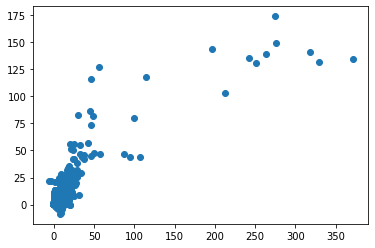

In [90]:
plt.scatter(X_train_level2[:, 0], X_train_level2[:, 1])

# Ensembling

When the meta-features are created, we can ensemble our first level models.

## Simple Convex Mix

We need to find an optimal $\alpha$. And it is very easy, as it is feasible to do grid search. Next, find the optimal $\alpha$ out of `alphas_to_try` array. 

In [91]:
alphas_to_try = np.linspace(0, 1, 1001)

r2_scores = np.array([r2_score(y_train_level2, np.dot(X_train_level2, [alpha, 1 - alpha])) for alpha in alphas_to_try])
best_alpha = alphas_to_try[r2_scores.argmax()] 
r2_train_simple_mix = r2_scores.max() 

print(f'Best alpha: {best_alpha}; Corresponding r2 score on train: {r2_train_simple_mix}')

Best alpha: 0.762; Corresponding r2 score on train: 0.6271958302095351


Now use the $\alpha$ you've found to compute predictions for the test set 

In [92]:
test_preds = best_alpha * pred_lr + (1 - best_alpha) * pred_lgb 
r2_test_simple_mix = r2_score(y_test, test_preds)

print(f'Test R-squared for simple mix is {r2_test_simple_mix}')

Test R-squared for simple mix is 0.7812102964363891


## Stacking

A more advanced ensembling technique. Fit a linear regression model to the meta-features. Use the same parameters as in the model above.

In [93]:
lr.fit(X_train_level2, y_train_level2)

print(f'Coefficient:            {lr.coef_}')
print(f'Normalized Coefficient: {lr.coef_ / lr.coef_.sum()}')

Coefficient:            [0.80668174 0.09546006]
Normalized Coefficient: [0.89418508 0.10581492]


In [94]:
train_preds = lr.predict(X_train_level2) 
r2_train_stacking = r2_score(y_train_level2, train_preds) 

test_preds = lr.predict(np.vstack((pred_lr, pred_lgb)).T) 
r2_test_stacking = r2_score(y_test, test_preds) 

print(f'Train R-squared for stacking is {r2_train_stacking}')
print(f'Test  R-squared for stacking is {r2_test_stacking}')

Train R-squared for stacking is 0.632092200807368
Test  R-squared for stacking is 0.771341806729652
